# Beware of foul-smelling mushrooms

## Binary Classification Problem: Is this mushroom poisonous or not? 

Using the [mushroom dataset], we will study how a machine learning model can predict whether a mushroom is poisonous or not given its features.
While this dataset  was originally curated more than 30 years ago by the UCI Machine Learning repository, mushroom hunting is still relevant to this day and the data provides for a good case-study of modeling with categorical variables only.

In this notebook, we will survey the various steps of a data science project:
- Data Preparation
- Exploratory Data Analysis
- Feature Selection
- Data Modeling
- Hyperparameter Tuning 

By doing so we will find out which features are most indicative of a poisonous mushroom and see which machine learning models perform best for this task.

[mushroom dataset]: https://archive.ics.uci.edu/ml/datasets/Mushroom

## Dataset

This dataset is known as the mushroom dataset. It includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. The field guide from which the mushroom records were drawn clearly states that there is no simple rule for determining the edibility of a mushroom, and it is common knowledge that if you are not able to identify a mushroom with confidence, you should not pick it. However, for experimentation purposes, we will study how well various machine learning models can predict whether a mushroom is poisonous or not given its physical characteristics. 

There are 22 attributes, which are all categorical, and 8124 training instances. The goal is to predict the binary class 'poisonous' or 'edible'. 

### Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import scipy.stats as ss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Data Preparation

First, we need to load the data and clean it. The cleaning process in our case will include:
- Deleting columns that contain a single value
- Checking for missing values
- Converting categorical values to ordinal values

In [2]:
df = pd.read_csv("data/mushrooms.csv")
print('Name of the attributes: \n{}'.format(df.columns))

Name of the attributes: 
Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


In [3]:
print('Size of the dataset: {}'.format(df.shape))

Size of the dataset: (8124, 23)


In [4]:
description_df = df.describe()
description_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Using the describe() method, we can retrieve the number of unique values for each column in a dataframe. We delete columns with only one value, which add no information for this classification task.

In [5]:
for col in description_df:
    if description_df[col].loc['unique'] < 2:
        print(('Deleted column: {}'.format(col)))
        df = df.drop([col], axis=1)

Deleted column: veil-type


Checking for missing values

In [6]:
col_names = list(df.columns)
num_missing = (df[col_names].isnull()).sum()
print('There are {} columns with missing values.'.format(len([i for i in num_missing if i > 0])))

There are 0 columns with missing values.


We convert the data from categorical to ordinal using LabelEncoder from scikit-learn. We store the mappings of each value with its ordinal representation in a dictionary for later use.

In [7]:
le = LabelEncoder()
label_df = pd.DataFrame()
for col in df.columns:
    label_df[col] = le.fit_transform(df[col])

Such integer representation can, however, not be used directly with estimators that expect continuous input and would interpret the categories as being ordered, which is not desired (i.e. the set of browsers was ordered arbitrarily).

Another possibility to convert categorical features to features is to use a one-hot encoding. This type of encoding can be obtained by transforming each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0.

In [8]:
onehot_df = pd.get_dummies(df)
onehot_df.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Double checking our cleaned data

In [9]:
print(label_df.info())
print(onehot_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
class                       8124 non-null int32
cap-shape                   8124 non-null int32
cap-surface                 8124 non-null int32
cap-color                   8124 non-null int32
bruises                     8124 non-null int32
odor                        8124 non-null int32
gill-attachment             8124 non-null int32
gill-spacing                8124 non-null int32
gill-size                   8124 non-null int32
gill-color                  8124 non-null int32
stalk-shape                 8124 non-null int32
stalk-root                  8124 non-null int32
stalk-surface-above-ring    8124 non-null int32
stalk-surface-below-ring    8124 non-null int32
stalk-color-above-ring      8124 non-null int32
stalk-color-below-ring      8124 non-null int32
veil-color                  8124 non-null int32
ring-number                 8124 non-null int32
ring-type                   8

## Exploratory Data Analysis 

This process can be likened to getting to know our data. By analysing how the features relate to each other, we gain crucial knowledge about the data which will helps us train efficient models.

One important thing to consider first is whether the dataset is balanced, i.e. whether the dataset contains the same number of samples from the positive and negative class.

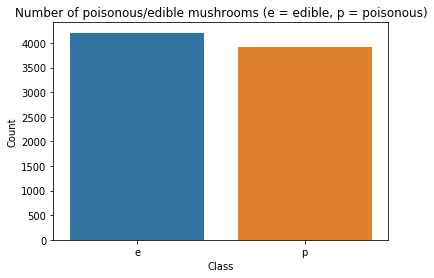

In [10]:
binary_class = pd.Series(df['class']).value_counts().sort_index()
sns.barplot(binary_class.index, binary_class.values)
plt.ylabel("Count")
plt.xlabel("Class")
plt.title('Number of poisonous/edible mushrooms (e = edible, p = poisonous)');

Are there any correlated features? We could consider deleting one of two features that are strongly correlated, as they contain similar information. Correlated features in general don't improve models, but they affect specific models in different ways and to varying extents:
- For linear models (e.g., linear regression or logistic regression), multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.
- Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

More generally, a simpler model is preferable, and, in some sense, a model with fewer features is simpler.

Please note that this is just an indication and might not be entirely reliable as we are using categorical variables encoded as labels.

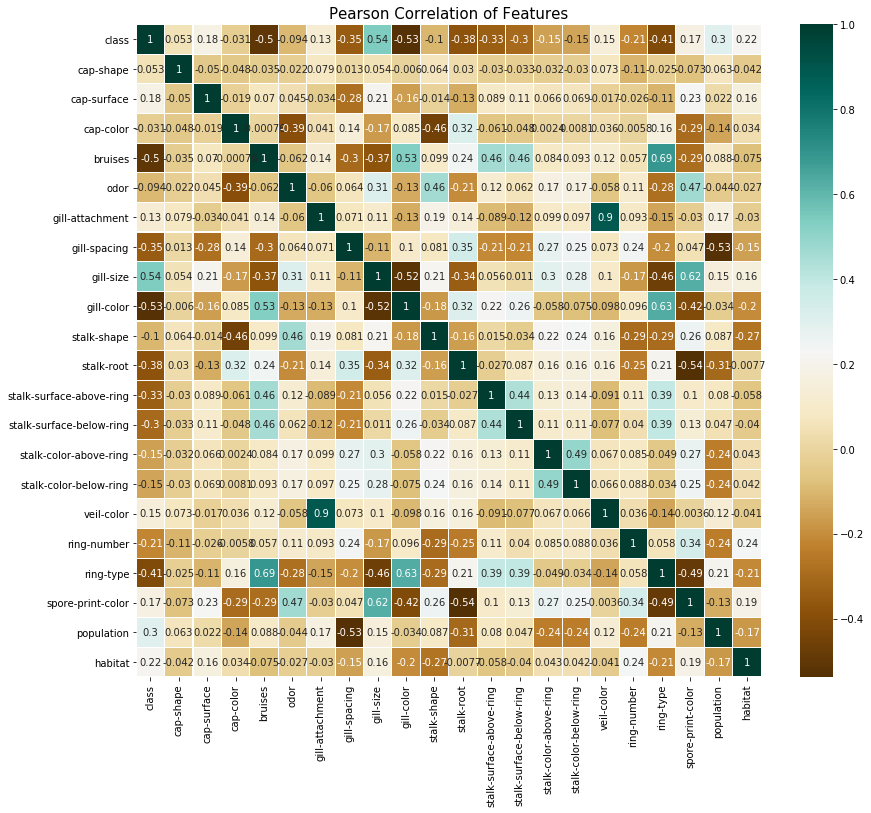

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(label_df.corr(),linewidths=.1,cmap="BrBG", annot=True)
plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.yticks(rotation=0);

In this case, 'gill-attachment' is strongly correlated with 'veil-color' (0.9).

Plotting the data using a violin plot allows us to identify which characteristics might be relevant for classification.

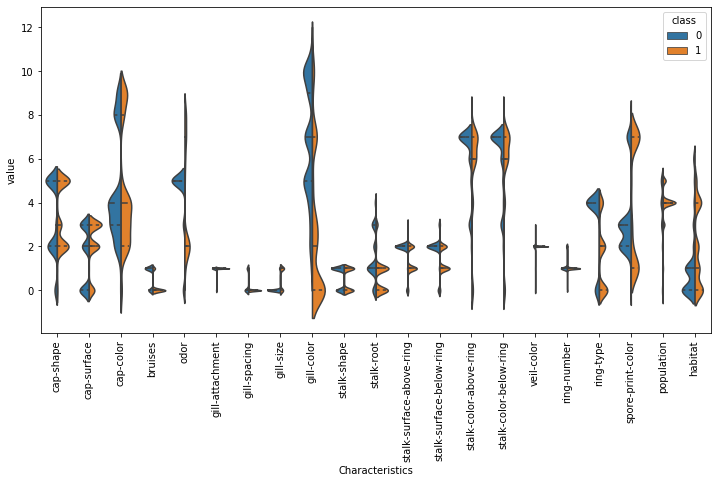

In [13]:
df_long = pd.melt(label_df, 'class', var_name='Characteristics')
fig, ax = plt.subplots(figsize=(12,6))
plot = sns.violinplot(ax=ax, x='Characteristics', y='value', hue='class', split=True, data=df_long, inner='quartile')
df_no_class = label_df.drop(['class'], axis=1)
plot.set_xticklabels(rotation=90, labels=list(df_no_class.columns));

By the looks of this plot, two variables seem to have a strong influence on whether a mushroom is poisonous or not: 'gill-color', and 'spore-print-color'.

To be more systematic, we can check for correlation between the categorical features. Cramer's V statistical test allows us to measure the strength of the association between categorical variables. It is based on Pearson's chi-squared statistic and has the advantage of giving good norming from 0 to 1 regardless of table size. (Code taken from https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix)

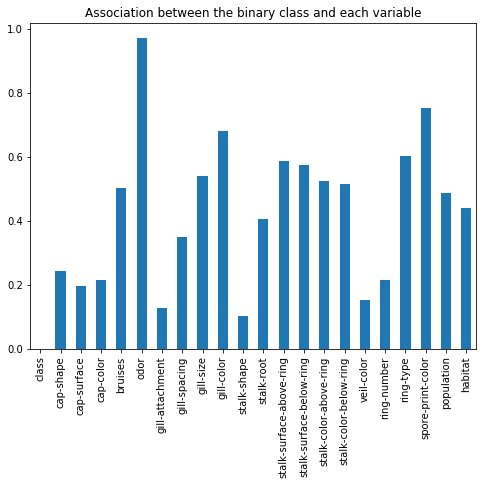

In [14]:
def cramers_corrected_stat(x,y):
    
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    conf_matrix=pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(conf_matrix)[0]
    n = sum(conf_matrix.sum())
    phi2 = chi2/n
    r,k = conf_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    result = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

corrM = np.zeros((len(col_names), len(col_names)))
for col1, col2 in itertools.combinations(col_names, 2):
    idx1, idx2 = col_names.index(col1), col_names.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(label_df[col1], label_df[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=col_names, columns=col_names)
corr['class'].plot(kind='bar', figsize=(8,6), title="Association between the binary class and each variable");

This plot confirms our intuition and reveals other relevant features that were less obvious such as 'odor'.

Let's plot the three most correlated features according to each individual characteristics and see how they relate to real-world characteristics. This might come in handy the next time you are going shroom hunting.

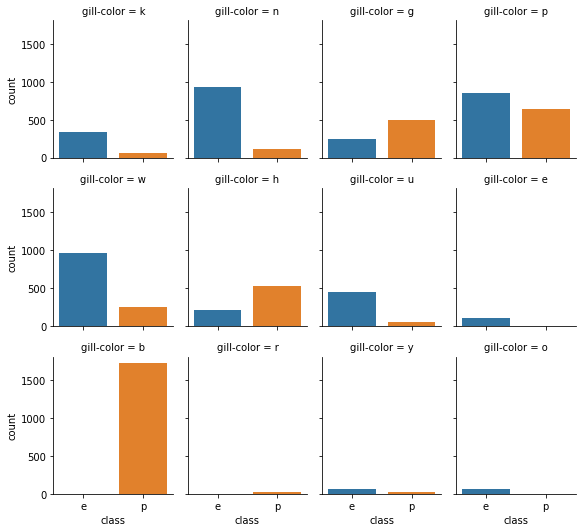

In [15]:
new_var = df[['class', 'gill-color']]
sns.catplot('class', col='gill-color', data=new_var, kind='count', height=2.5, aspect=.8, col_wrap=4, order=['e', 'p']);

gill-color: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y 

Watch out for buff (light brownish yellow) gills!

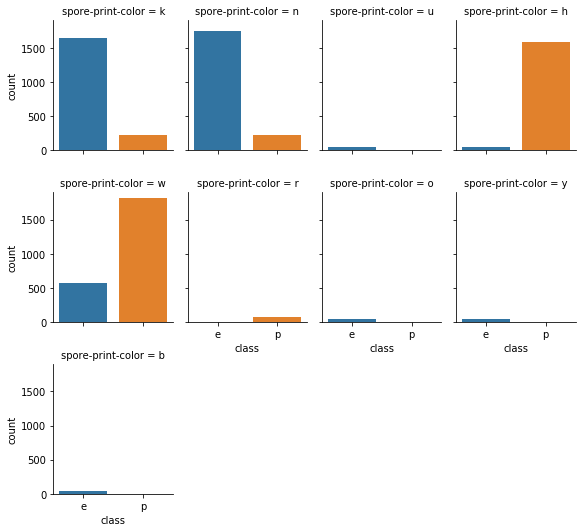

In [16]:
new_var = df[['class', 'spore-print-color']]
sns.catplot('class', col='spore-print-color', data=new_var, kind='count', height=2.5, aspect=.8, col_wrap=4, order=['e', 'p']);

spore-print-color: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y

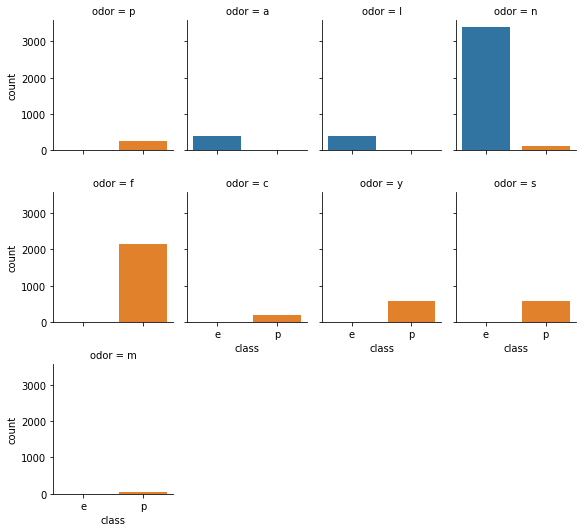

In [17]:
new_var = df[['class', 'odor']]
sns.catplot('class', col='odor', data=new_var, kind='count', height=2.5, aspect=.8, col_wrap=4, order=['e', 'p']);

odor: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s

You know what to do if a mushroom is foul-smelling...

## Feature Selection

Feature selection is the automatic selection of features that are most relevant to a predictive modeling problem.

The objective of feature selection is three-fold:
- improving the prediction performance of the models
- providing faster and more cost-effective models
- providing a better understanding of the underlying process that generated the data

There are three general classes of feature selection algorithms: filter methods, wrapper methods and embedded methods. Here we will focus on filter methods and show how they can be implemented using scikit-learn.

Having irrelevant features in the data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression. Let's see how using filter methods such as the Chi-squared test and information gain and selecting the top 25 features affects the prediction performance.

Splitting training and testing data

In [18]:
X = onehot_df.drop(['class_e', 'class_p'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Model built using all features

In [19]:
# fit the model
model = LogisticRegression()
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
print('Accuracy (all features): %.2f' % (accuracy_score(y_test, y_pred)))

Accuracy (all features): 1.00


In [20]:
# feature selection
def select_features(X_train, y_train, X_test, method):
    fs = SelectKBest(score_func=method, k=25)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Model built using chi-squared features

Top 10 chi-squared features: 

odor_n: 1920.485806
odor_f: 1566.084960
stalk-surface-above-ring_k: 1380.807527
stalk-surface-below-ring_k: 1306.630206
gill-color_b: 1263.915040
gill-size_n: 1124.382043
spore-print-color_h: 1045.571404
ring-type_l: 933.585917
bruises_t: 825.153563
ring-type_p: 821.472306


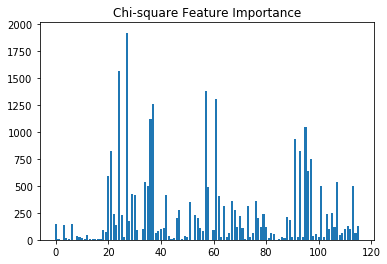

In [21]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, chi2)
# what are scores for the features
feature_scores = [tup for tup in zip(fs.scores_, X.columns)]
print('Top 10 chi-squared features: \n')
for i, j in sorted(feature_scores, key=lambda tup: tup[0], reverse=True)[:10]:
    print('%s: %f' % (j, i))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Chi-square Feature Importance')
plt.show()

In [22]:
# fit the model
model = LogisticRegression()
model.fit(X_train_fs, y_train)
# evaluate the model
y_pred = model.predict(X_test_fs)
# evaluate predictions
print('Accuracy (chi-squared features): %.2f' % (accuracy_score(y_test, y_pred)))

Accuracy (chi-squared features): 0.97


Model built using Mutual Information features:

Top 10 Mutual Information features: 

odor_n: 0.377817
odor_f: 0.248675
stalk-surface-above-ring_k: 0.203592
stalk-surface-below-ring_k: 0.191095
gill-color_b: 0.186032
gill-size_n: 0.174420
gill-size_b: 0.159555
ring-type_p: 0.155762
bruises_f: 0.144437
stalk-surface-above-ring_s: 0.141244


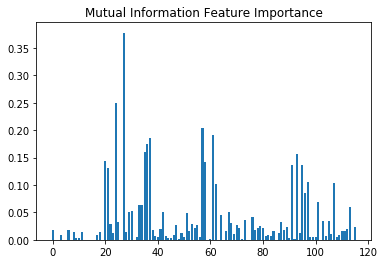

In [23]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_classif)
# what are scores for the features
feature_scores = [tup for tup in zip(fs.scores_, X.columns)]
print('Top 10 Mutual Information features: \n')
for i, j in sorted(feature_scores, key=lambda tup: tup[0], reverse=True)[:10]:
    print('%s: %f' % (j, i))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Mutual Information Feature Importance')
plt.show()

In [24]:
# fit the model
model = LogisticRegression()
model.fit(X_train_fs, y_train)
# evaluate the model
y_pred = model.predict(X_test_fs)
# evaluate predictions
print('Accuracy (Mutual Information features): %.2f' % (accuracy_score(y_test, y_pred)))

Accuracy (Mutual Information features): 0.97


Both methods are selecting the same features as most relevant with some variations. However they both result in a worsened accuracy. This can be explained by the fact that the number of features in the dataset is relatively low to begin with.  

Another filtering method is to ignore features with low variance. These features can be dismissed as they do not contribute to the model's accuracy. Here we retrieve the standard deviation from the ordinally encoded features. We could then set a threshold below which features would be dismissed and test if the model performs better with fewer features.

In [25]:
descr = label_df.describe()
descr.loc['std'].sort_values(ascending=False)

gill-color                  3.540359
cap-color                   2.545821
spore-print-color           2.382663
odor                        2.103729
stalk-color-below-ring      1.907291
stalk-color-above-ring      1.901747
ring-type                   1.801672
habitat                     1.719975
cap-shape                   1.604329
population                  1.252082
cap-surface                 1.229873
stalk-root                  1.061106
stalk-surface-below-ring    0.675974
stalk-surface-above-ring    0.621459
class                       0.499708
stalk-shape                 0.495493
bruises                     0.492848
gill-size                   0.462195
gill-spacing                0.368011
ring-number                 0.271064
veil-color                  0.242669
gill-attachment             0.158695
Name: std, dtype: float64

## Data Modeling

When it comes to machine learning algorithms, there is no one-size-fits-all. Depending on the task and the data, different models might perform better. Thus, the best approach is to try various models, tune them and compare how they perform.

Let's see how some of the most common classification models perform on this task.

In [26]:
models = [SVC(kernel='rbf', random_state=0), SVC(kernel='linear', random_state=0), XGBClassifier(), LogisticRegression(), KNeighborsClassifier()]
model_names = ['SVC_rbf', 'SVC_linear', 'xgboost', 'Logistic Regression', 'KNeighbors Classifier']
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print ('Accurancy of ' + model_names[i] + ': ' + str(accuracy_score(y_test, y_pred)))

Accurancy of SVC_rbf: 1.0
Accurancy of SVC_linear: 1.0
Accurancy of xgboost: 1.0
Accurancy of Logistic Regression: 1.0
Accurancy of KNeighbors Classifier: 1.0


It turns out this problem is easily solved by modern predictors. For more interpretability, let's find out which features are given more importance by various models.

In [27]:
feature_scores = [tup for tup in zip(models[3].coef_[0], X.columns)]
print('Top 10 Logistic Regression features: \n')
for i, j in sorted(feature_scores, key=lambda tup: tup[0], reverse=True)[:10]:
    print('%s: %f' % (j, i))

Top 10 Logistic Regression features: 

spore-print-color_r: 3.281522
odor_f: 2.569006
odor_c: 2.548202
stalk-root_b: 2.249995
odor_p: 2.120416
gill-size_n: 2.071249
gill-color_b: 1.782190
stalk-surface-above-ring_k: 1.651549
gill-spacing_c: 1.427066
stalk-surface-below-ring_y: 1.224248


In [28]:
feature_scores = [tup for tup in zip(models[2].feature_importances_, X.columns)]
print('Top 10 xgboost features: \n')
for i, j in sorted(feature_scores, key=lambda tup: tup[0], reverse=True)[:10]:
    print('%s: %f' % (j, i))

Top 10 xgboost features: 

stalk-root_c: 0.276387
odor_n: 0.259561
stalk-root_r: 0.162569
odor_a: 0.071532
odor_l: 0.068792
spore-print-color_r: 0.041873
odor_p: 0.023088
stalk-surface-below-ring_y: 0.022314
bruises_f: 0.019040
cap-color_y: 0.015035


We can observe that different models use the data in different ways, though there are some similarities in what features are considered most important.

Now let's see how a simple Decision Tree Classifier does. This model has the advantage of being highly interpretable and is well-suited for categorical variables. In this tree, each node represents a feature and the leaves correspond to the predicted outcome.

Accuracy of Decision Tree Classifier: 1.0
Top 10 Decision Tree features: 

odor_n: 0.629049
stalk-root_c: 0.174072
stalk-root_r: 0.081133
spore-print-color_r: 0.033052
odor_a: 0.022031
odor_l: 0.021102
bruises_t: 0.017763
stalk-surface-below-ring_y: 0.012504
stalk-root_b: 0.005623
cap-shape_c: 0.001467


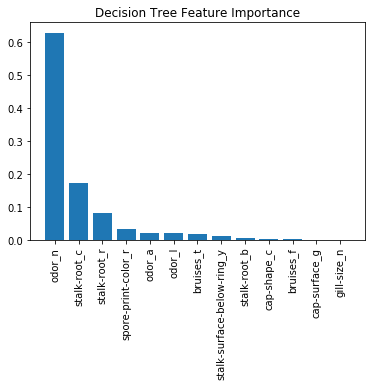

In [29]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print ('Accuracy of Decision Tree Classifier: ' + str(accuracy_score(y_test, tree_clf.predict(X_test))))

importances = tree_clf.feature_importances_
feature_scores = [tup for tup in zip(importances, X.columns)]
print('Top 10 Decision Tree features: \n')
sorted_scores = sorted(feature_scores, key=lambda tup: tup[0], reverse=True)
for i, j in sorted_scores[:10]:
    print('%s: %f' % (j, i))
    
# plot the scores
plt.bar([j for i, j in sorted_scores[:13]], sorted(importances, reverse=True)[:13])
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)
plt.show()

Interestingly, only three features account for about 90% of the information the Decision Tree Classifier needs to achieve 100% accuracy. The feature 'odor-n' (n = none) is a key deciding factor for this task.

We can visualize and interpret how the tree classifier makes decisions by plotting it.

Double-click on the image to enlarge it


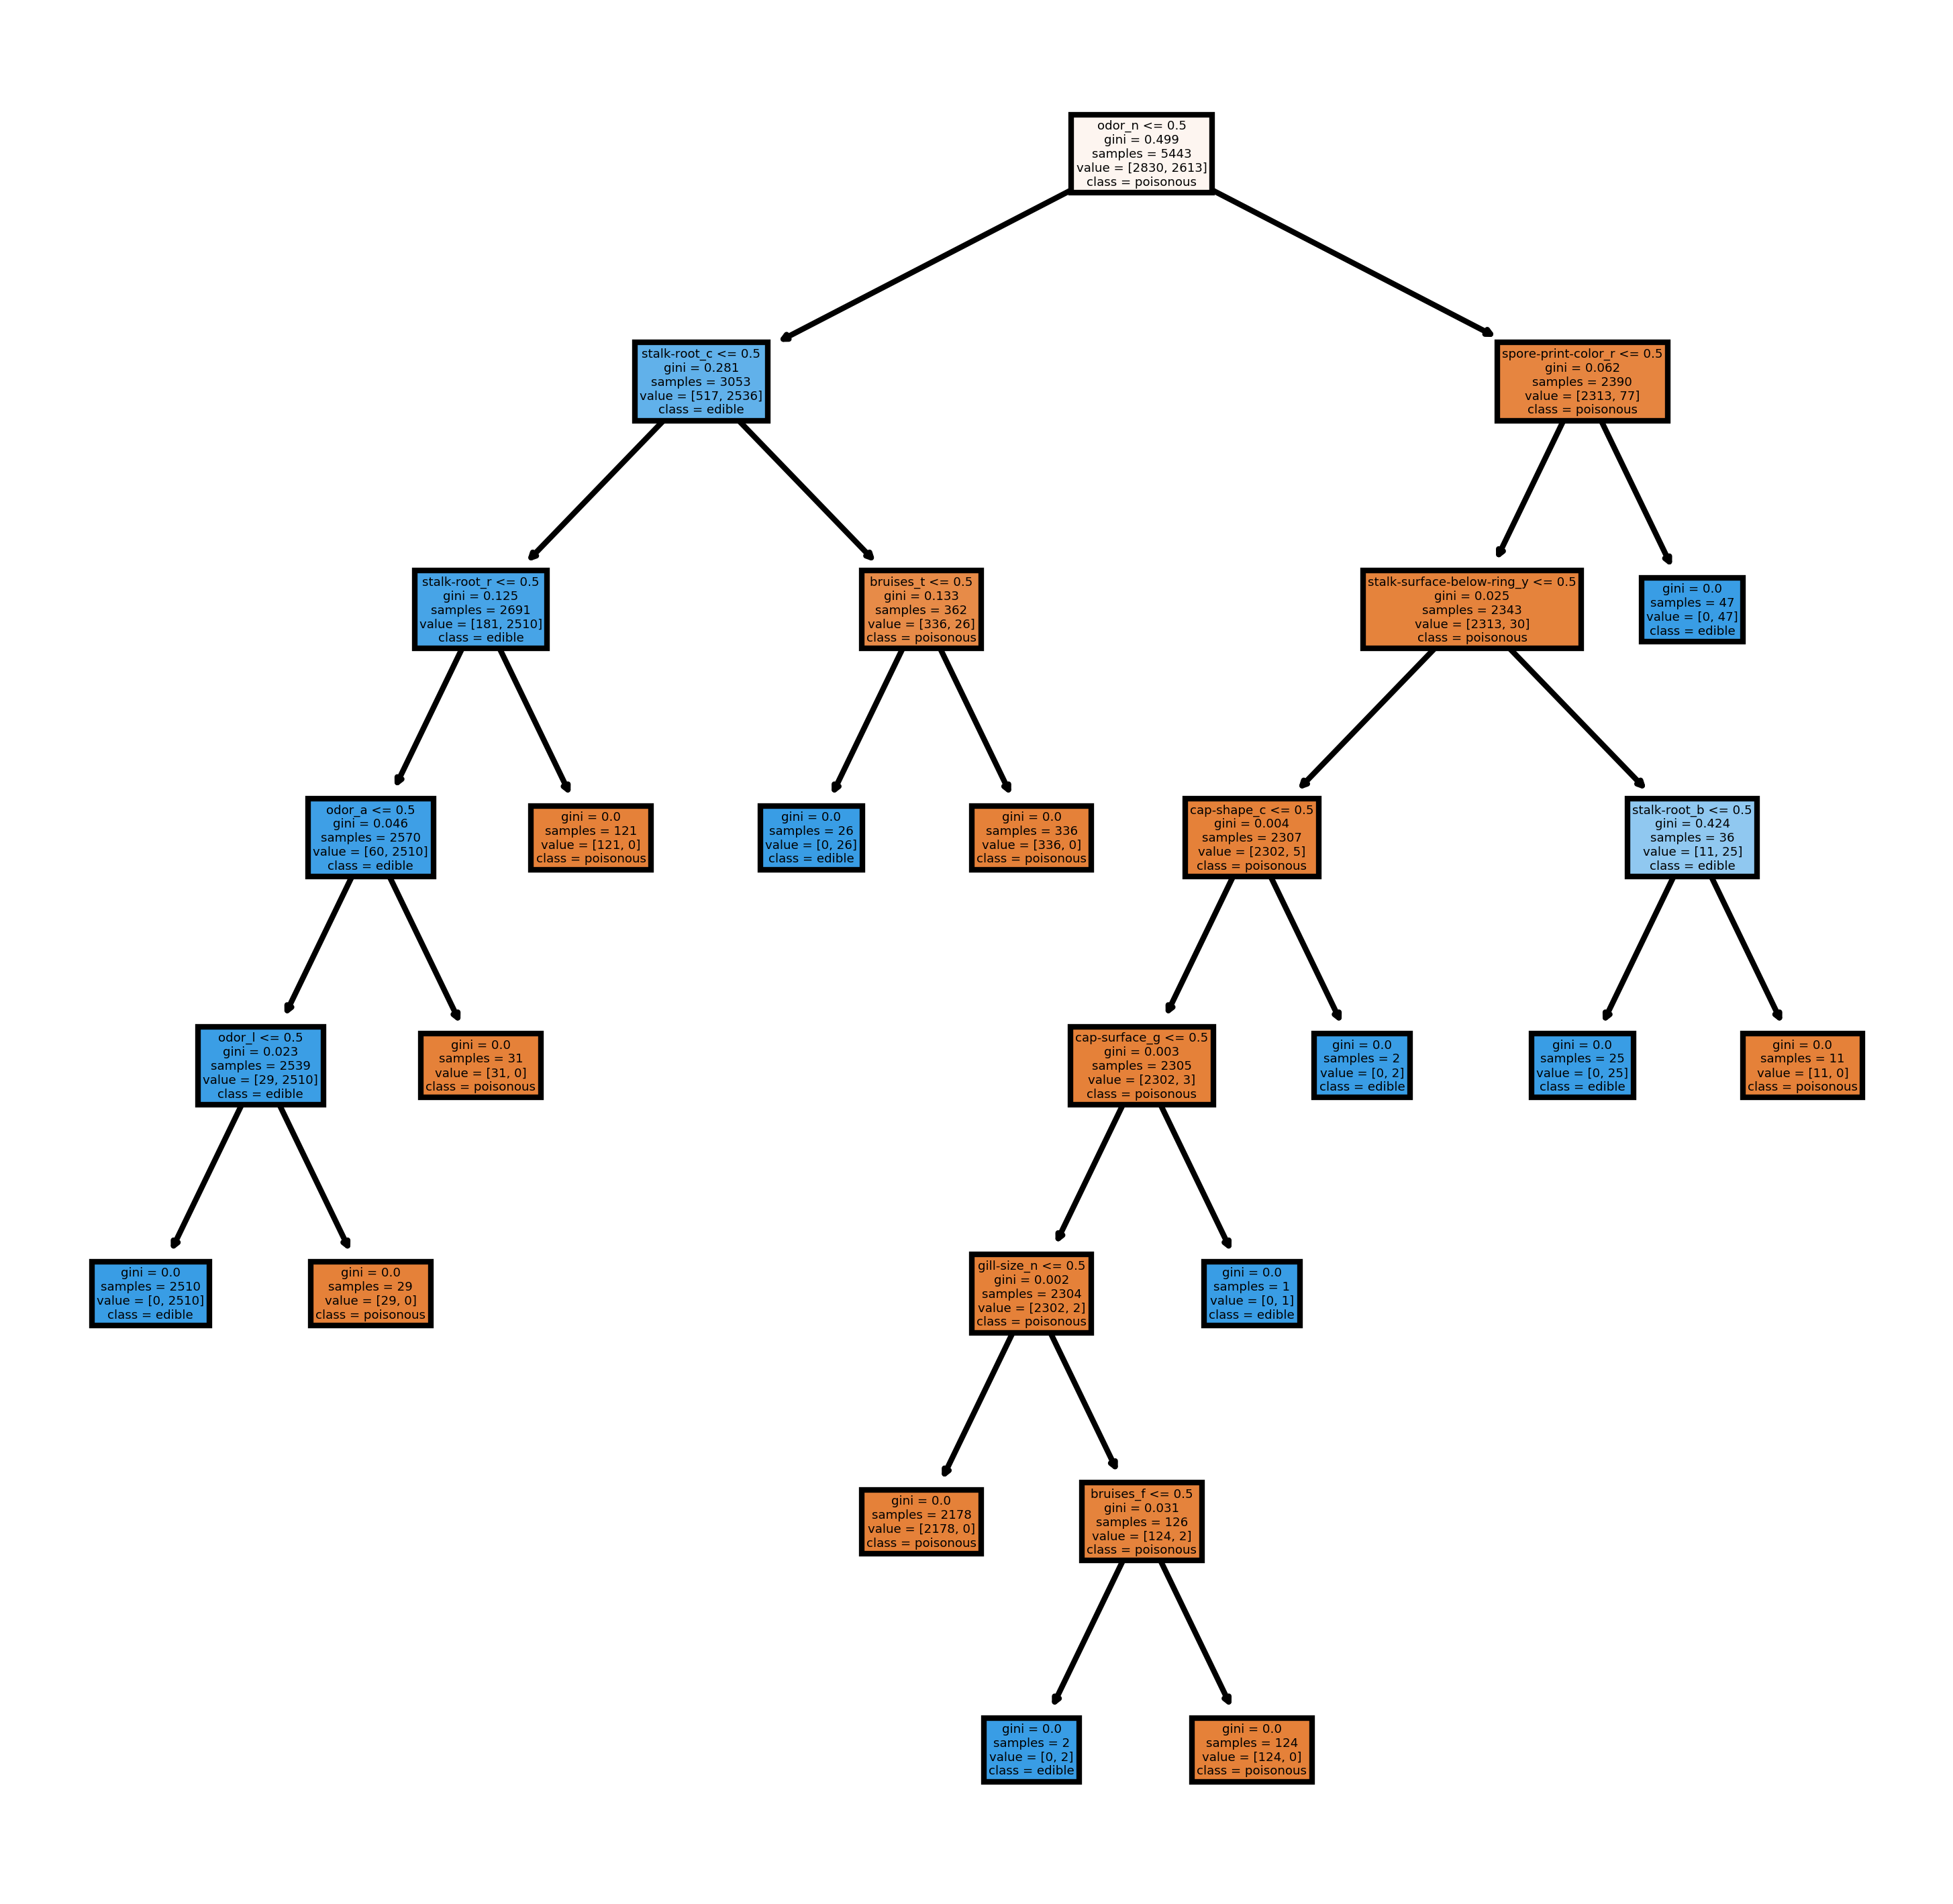

In [36]:
print('Double-click on the image to enlarge it')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=600)
plot_tree(tree_clf,
            feature_names=list(X_train.columns), 
            class_names=['poisonous', 'edible'],
            filled=True);

## Hyperparameter Tuning

For the sake of demonstration, we will perform hyperparameter tuning, the final step that would help bring up the performance of the predictor. We can find which combination of hyperparameters performs best by using a randomized search. RandomizedSearchCV samples from a set of pre-defined hyperparameters and fits various models with different combinations of paramaters using k-fold cross-validation. The most accurate model can then be retrieved.

We will use a Random Forest Classifier, an ensemble method that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control overfitting.

In [33]:
RR_model = RandomForestClassifier()

parameters = {'min_samples_leaf': range(10,100,10), 
                    'n_estimators' : range(10,100,10),
                    'criterion' : ['gini', 'entropy'],
                    'max_features':['auto','sqrt','log2']
                    }

RR_model = RandomizedSearchCV(RR_model, parameters, cv=10, scoring='accuracy', n_iter=20, n_jobs=-1)
RR_model.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

Make predictions and display scoring metrics

In [34]:
y_pred = RR_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1378
           p       1.00      1.00      1.00      1303

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



We can display the results report using pandas. This comprehensive report may be useful to inspect all the parameter settings and do a narrower grid search using the most optimal combinations of parameters.

In [35]:
scores_df = pd.DataFrame(RR_model.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_criterion,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.039259,0.124635,0.049403,0.008594,70,20,auto,entropy,"{'n_estimators': 70, 'min_samples_leaf': 20, '...",0.998165,...,1.0,0.992647,0.996324,0.996324,0.998162,0.996324,1.0,0.997794,0.002296,1
1,0.768344,0.105036,0.043303,0.010150,50,20,auto,gini,"{'n_estimators': 50, 'min_samples_leaf': 20, '...",0.998165,...,1.0,0.992647,0.996324,0.996324,0.998162,0.996324,1.0,0.997794,0.002296,1
2,0.750243,0.126448,0.038602,0.003262,50,10,log2,entropy,"{'n_estimators': 50, 'min_samples_leaf': 10, '...",0.998165,...,1.0,0.992647,0.996324,0.996324,0.998162,0.996324,1.0,0.997794,0.002296,1
3,0.482928,0.068361,0.026402,0.005389,30,20,auto,gini,"{'n_estimators': 30, 'min_samples_leaf': 20, '...",0.998165,...,1.0,0.987132,0.996324,0.996324,0.998162,0.996324,1.0,0.997059,0.003602,4
4,0.609935,0.115506,0.042802,0.016309,40,20,log2,gini,"{'n_estimators': 40, 'min_samples_leaf': 20, '...",0.992661,...,1.0,0.992647,0.996324,0.996324,0.992647,0.990809,1.0,0.995958,0.003368,5


## Conclusion

We have surveyed the various steps of a data science project and how to deal with categorical variables. While this dataset is rather old and modern predictors easily reach 100\% accuracy, it still serves as an interesting basis for exploratory analysis.

If you do decide to go mushroom hunting next season, please only pick those you can identify with confidence.

That's it, thanks for reading!